# Convolutional Network Implementation

In [1]:
import skimage.data as data
import numpy as np
import math

from skimage import color
from skimage.transform import resize
from matplotlib import pyplot as plt

%matplotlib inline

## Data Preprocessing

D:\Users\bisqwit\Anaconda2\envs\cs231n\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Users\bisqwit\Anaconda2\envs\cs231n\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


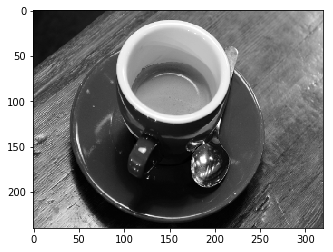

In [2]:
image = data.coffee()                 # astronaut,chelsea,coffee,camera
image = color.rgb2gray(image)

image = resize(image,(240,320))

plt.imshow(image, cmap='gray')

In [3]:
image.shape

(240, 320)

## Feature Filters

In [4]:
conv_0_filters = np.zeros((2,3,3))

conv_0_filters[0,:,:] = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])      # Horizontal filter
conv_0_filters[1,:,:] = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])      # Vertical filter

conv_0_filters.shape

(2, 3, 3)

## Convolution Layer

In [5]:
def relu(x):
    return x * (x > 0.0)

def flatten(x):
    return x.reshape((x.shape[0]*x.shape[1]*x.shape[2]),-1)

In [6]:
def plot_images(images):
    plt.figure(figsize=(10,10))
    for i,img in enumerate(images):
        plt.subplot(1,images.shape[0],1+i)
        plt.imshow(img)

In [7]:
def dimension(height,width,kernel_size,stride,padding):
    '''
    Description: Returns the dimensions,height and width, of a feature map.
    '''
    if stride > kernel_size:
        raise Exception('stride must be less or equal to kernel_size.')
    
    pad_size=0
    
    if padding == 'same' and kernel_size!=2:
        if stride == 1:
            pad_size = np.uint32(math.ceil((kernel_size-1)/2))
        else:
            raise Exception('padding=same works with stride=1')
        
    xdim = np.uint32(math.ceil(height+2*pad_size-kernel_size)/stride)+1
    ydim = np.uint32(math.ceil(width+2*pad_size-kernel_size)/stride)+1
    
    return (xdim,ydim,pad_size)

In [8]:
def kernel_scan(image,n_filter,kernel_size,stride,height,width,activation=None):
    '''
    Description: Uses a kernel to scan through an image, and returns a feature map.
    '''
    feature_map = np.zeros((1,height,width))
    for rx,x in enumerate(range(0,image.shape[0]-kernel_size,stride)):
        for ry,y in enumerate(range(0,image.shape[1]-kernel_size,stride)):
            curr_region = image[x:(x+kernel_size),y:(y+kernel_size)]
            dot_product = curr_region * n_filter
            results = np.sum(dot_product)
                
            if activation is not None:
                results = activation(results)
            feature_map[0,rx,ry] = results
    return feature_map

In [9]:
def conv2D(image,filters,stride=1,padding='valid',activation=None):
    '''
    Description: Uses kernels to scan through an image, and returns a list of feature maps.
    '''
    kernel_size = filters.shape[1]
    xdim,ydim = (0,1)
    
    if len(image.shape)>2:
        xdim,ydim = (1,2)
    
    height,width,_ = dimension(image.shape[xdim],image.shape[ydim],kernel_size,stride,padding)
    feature_maps   = np.zeros((filters.shape[0],height,width))
    
    if len(image.shape)>2:
        for i,(n_filter,n_image) in enumerate(zip(filters,image)):
            feature_maps[i,:,:] = kernel_scan(n_image,n_filter,kernel_size,stride,height,width,activation)
    else:
        for i,n_filter in enumerate(filters):
            feature_maps[i,:,:] = kernel_scan(image,n_filter,kernel_size,stride,height,width,activation)
    return feature_maps

In [10]:
conv_0_feature_map = conv2D(image,conv_0_filters,padding='same',activation=relu)
conv_0_feature_map.shape

(2, 240, 320)

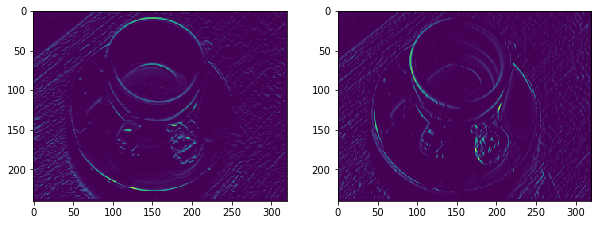

In [11]:
 plot_images(conv_0_feature_map)

## Max Pooling

In [21]:
def maxPooling2D(feature_maps,kernel_size=2,stride=2, padding='valid'):
    '''
    Description: Performs max pooling by selecting the highest element in the window kernel,
                 and returns a list of "poolings".
    '''
    height,width,_ = dimension(feature_maps.shape[1],feature_maps.shape[2],kernel_size,stride,padding)
    poolings = np.zeros((feature_maps.shape[0],height,width))
    
    for i,feature_map in enumerate(feature_maps):
        for rx,x in enumerate(range(0,feature_map.shape[0]-kernel_size,stride)):
            for ry,y in enumerate(range(0,feature_map.shape[1]-kernel_size,stride)):
                poolings[i,rx,ry] = np.max(feature_map[x:x+kernel_size,y:y+kernel_size])
    return poolings

In [13]:
pooled_0_features = maxPooling2D(conv_0_feature_map,kernel_size=2,stride=2)
pooled_0_features.shape

(2, 120, 160)

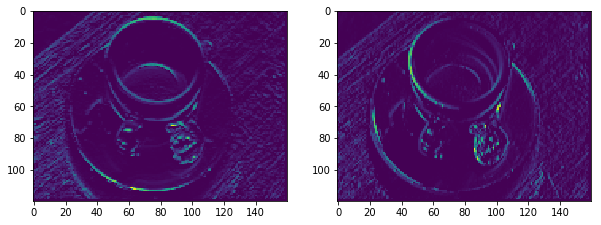

In [14]:
plot_images(pooled_0_features)

In [15]:
conv_1_filters = np.zeros((2,3,3))

conv_1_filters[0,:,:] = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
conv_1_filters[1,:,:] = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

conv_1_filters.shape

(2, 3, 3)

In [16]:
conv_1_feature_map = conv2D(pooled_0_features,conv_1_filters,padding='same',activation=relu)
conv_1_feature_map.shape

(2, 120, 160)

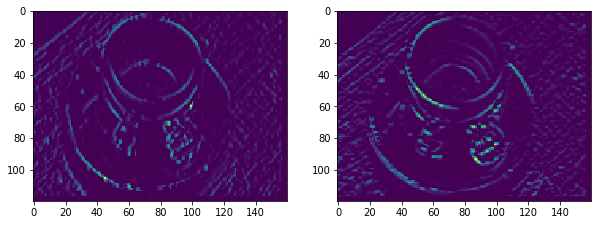

In [17]:
plot_images(conv_1_feature_map)

In [18]:
pooled_1_features = maxPooling2D(conv_1_feature_map,kernel_size=2,stride=2)
pooled_1_features.shape # z*n*m features to feed to the Fully Connected Neural Network

(2, 60, 80)

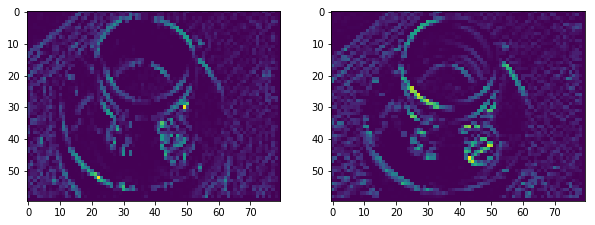

In [19]:
plot_images(pooled_1_features)

In [20]:
input_x = flatten(pooled_1_features)
print(input_x.shape)

(9600, 1)
